#### AAYUSH GOYAL
#### EE18BTECH11001
#### Assigment 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import ndimage
import pandas as pd
from matplotlib.patches import Ellipse
import emcee
import corner
from scipy import optimize

### Question 1

Bayes Score = $2.07621226610332088 * 10^{-11}$

### Question 2

In [2]:
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf 
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_llihood(theta, x, y):
    a,b,s = theta
    y_model = a + b * x
    return -0.5 * np.sum(np.log(2 * np.pi * s ** 2) + 
                         (y - y_model) ** 2 / s ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_llihood(theta, x, y)


def sigma_level(t1, t2, nbins=20, smoothing=3):
    L, xbins, ybins = np.histogram2d(t1, t2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    sigma = L_cumsum[i_unsort].reshape(shape)

    if smoothing > 1:
        sigma = ndimage.zoom(sigma, smoothing)
        xbins = np.linspace(xbins[0], xbins[-1], sigma.shape[0] + 1)
        ybins = np.linspace(ybins[0], ybins[-1], sigma.shape[1] + 1)
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, sigma


def plot_MCMC(ax, xdata, ydata, t, scatter=False, 
              nbins=20, smoothing=3, **kwargs):
    
    xbins, ybins, sigma = sigma_level(t[0], t[1],nbins, smoothing)

    ax.contour(xbins, ybins, sigma.T, 
               levels=[0.683 ** 2, 0.955 ** 2], **kwargs)
    if scatter:
        ax.plot(t[0], t[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')


def getPrincipal(sig):
    
    sigmax2 = sig[0, 0]
    sigmay2 = sig[1, 1]
    sigmaxy = sig[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigmaxy, sigmax2 - sigmay2)
    temp1 = 0.5 * (sigmax2 + sigmay2)
    temp2 = np.sqrt(0.25 * (sigmax2 - sigmay2) ** 2 + sigmaxy ** 2)

    return np.sqrt(temp1 + temp2), np.sqrt(temp1 - temp2), alpha

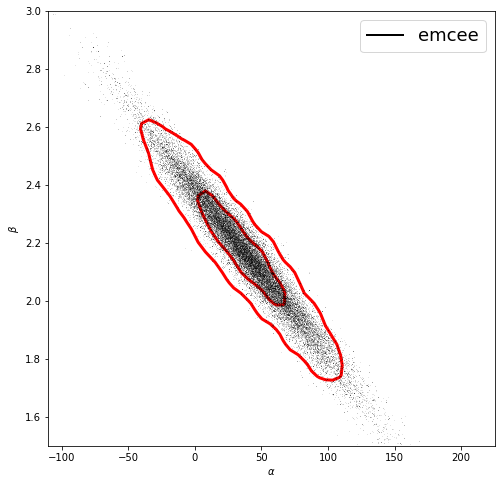

In [3]:
ndim = 3 
nwalkers = 50 
nburn = 1000 
nsteps = 2000 
np.random.seed(0)
guesses = np.random.random((nwalkers, ndim))
x = np.array([203,58,210,202,198,158,165,201,157,131,166,
              160,186,125,218,146])
y = np.array([495,173,479,504,510,416,393,442,317,311,
              400,337,423,334,533,344])
sigmay= np.array([21,15,27,14,30,16,14,25,52,16,34,
                  31,42,26,16,22])
np.random.seed(42)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                args=[x, y])
sampler.run_mcmc(guesses, nsteps)
emcee_ = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
fig, ax = plt.subplots(figsize=(8, 8))
plot_MCMC(ax, x, y, emcee_, True,colors='r', linewidths=3)
ax.plot([0, 0], [0, 0], 'black', lw=2)
ax.legend(ax.lines[-1:] + ax.collections[::2],
          ['emcee'], fontsize=18)

ax.set_xlim(-110, 225)
ax.set_ylim(1.5,3)
plt.show()

### Question 3

In [4]:
def mse(theta, x=x, y=y, sigmay=sigmay):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / sigmay) ** 2)


def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2 
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, x=x, y=y, sigmay=sigmay, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / sigmay, c).sum()
def log_prior(theta):
    
    if 1 > all(theta[2:]) > 0:
        return 0
    else:
        return -np.inf 

def log_llhood(theta, x, y, sigmay, sigmaB):
    dy = y - theta[0] - x*theta[1] 
    temp = np.clip(theta[2:], 0, 1) 
    lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2) 
    lL1=lL1- 0.5 * (dy / sigmay) ** 2
    lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2) 
    lL2+=- 0.5 * ((dy / sigmaB) ** 2)
    su =  np.sum(np.logaddexp(lL1, lL2))
    return su

def log_posterior(theta, x, y, sigmay, sigmaB):
    return log_prior(theta) + log_llhood(theta, x, y, sigmay, sigmaB)



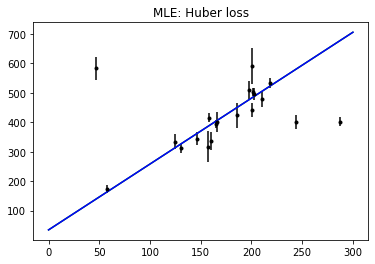

In [5]:
theta1 = optimize.fmin(mse, [0, 0], disp=False)
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
x = np.array([201,244,47,287,203,58,210,202,198,158,165,201,157,
              131,166,160,186,125,218,146])
y = np.array([592,401,583,402,495,173,479,504,510,416,393,
              442,317,311,400,337,423,334,533,344])
sigmay= np.array([61,25,38,15,21,15,27,14,30,16,
                  14,25,52,16,34,31,42,26,16,22])
fit = np.linspace(0, 300, 1000)
t = np.linspace(-20, 20)
plt.errorbar(x, y, sigmay, fmt='.k')
plt.plot(fit, theta1[0] + fit*theta1[1] , color='g')
plt.plot(fit, theta2[0] + fit*theta2[1], color='b')
plt.title('MLE: Huber loss');
plt.show()

/Users/aayush/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-4-517556746950>:22: RuntimeWarning: divide by zero encountered in log
  lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2) - 0.5 * ((dy / sigmaB) ** 2)
<ipython-input-4-517556746950>:21: RuntimeWarning: divide by zero encountered in log
  lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2) - 0.5 * (dy / sigmay) ** 2


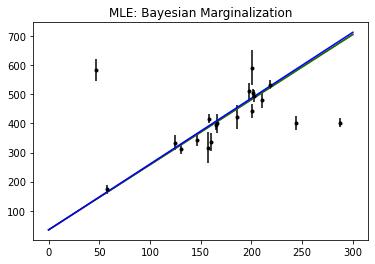

In [6]:
ndim = 2 + len(x) 
nwalkers = 50 
nburn = 10000 
nsteps = 15000  

np.random.seed(4)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta2, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                log_posterior, args=[x, y, sigmay, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain 
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.38)
plt.errorbar(x, y, sigmay, fmt='.k')
plt.plot(fit, theta1[0] + fit*theta1[1], color='r')
plt.plot(fit, theta2[0] + fit*theta2[1] , color='g')
plt.plot(fit, theta3[0] +  fit* theta3[1] , color='b')
plt.title('MLE: Bayesian Marginalization');
plt.show()